# RetinaNet with PyTorch

The dataset used can be found at https://www.kaggle.com/datasets/ipythonx/retinal-vessel-segmentation/data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using {torch.cuda.get_device_name(0)} device")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using {device} device")

Using NVIDIA GeForce GTX 1070 device
Using cuda device


# Load Data

In [3]:
class RetinaDataset(Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

In [4]:
def read_data(path):
    imgs = []
    masks = []
    subFolder = os.listdir(path)
    # remove mask folder if manual folder exists
    if "1st_manual" or "manual" in subFolder and "mask" in subFolder:
        subFolder.remove("mask")
    for folder in subFolder:
        if folder == "images":
            for img in os.listdir(os.path.join(path, folder)):
                imgs.append(plt.imread(os.path.join(path, folder, img)))
        # XOR manual and mask
        elif folder == "1st_manual" or folder == "mask":
            for mask in os.listdir(os.path.join(path, folder)):
                masks.append(plt.imread(os.path.join(path, folder, mask)))

    imgs = np.array(imgs)
    masks = np.array(masks)
    return imgs, masks

In [5]:
train_data = read_data("archive/DRIVE/training")
test_data = read_data("archive/DRIVE/test")

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_dataset = RetinaDataset(train_data[0], train_data[1], transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = RetinaDataset(test_data[0], test_data[1], transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Image Visualization

In [7]:
def show_image(img, mask, prediction=None):
    if prediction is not None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    ax[1].axis("off")
    if prediction is not None:
        ax[2].imshow(prediction)
        ax[2].set_title("Prediction")
        ax[2].axis("off")
    plt.show()

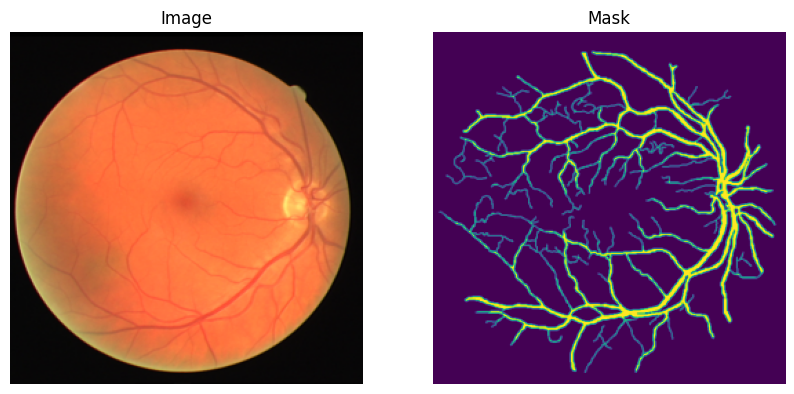

In [8]:
img, mask = train_loader.dataset[0]
show_image(img.permute(1, 2, 0), mask.permute(1, 2, 0))

# Model

In [9]:
import torch.nn as nn
from model import UNet
from loss import DiceLoss, DiceBCELoss

In [10]:
model = UNet(in_channels=3, out_channels=1)
model = model.to(device)

In [11]:
# Loss and optimizer for segmentation
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [12]:
# Train the model
total_step = len(train_loader)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        
        # Forward pass
        outputs = model(image)
        loss = criterion(outputs, mask)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [10/50], Loss: 1.095803141593933
Epoch [20/50], Loss: 1.0905269384384155
Epoch [30/50], Loss: 1.0735737085342407
Epoch [40/50], Loss: 1.0960568189620972
Epoch [50/50], Loss: 1.0405406951904297


# Test

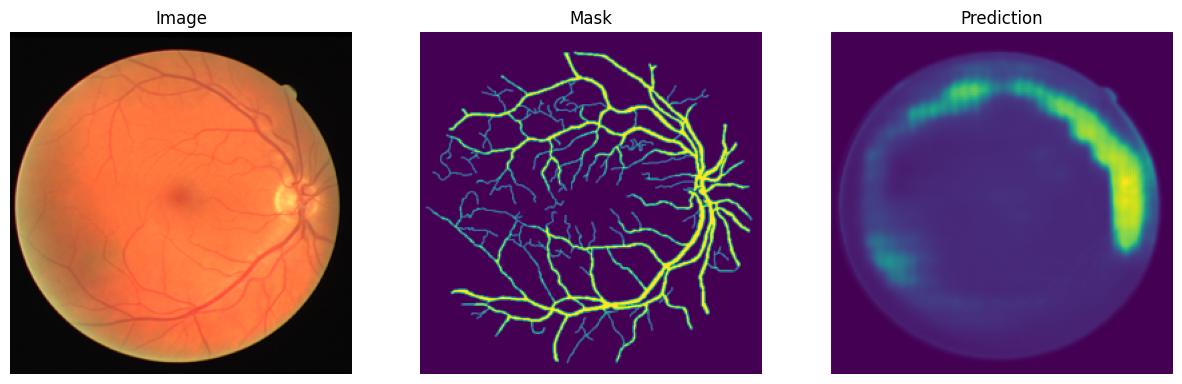

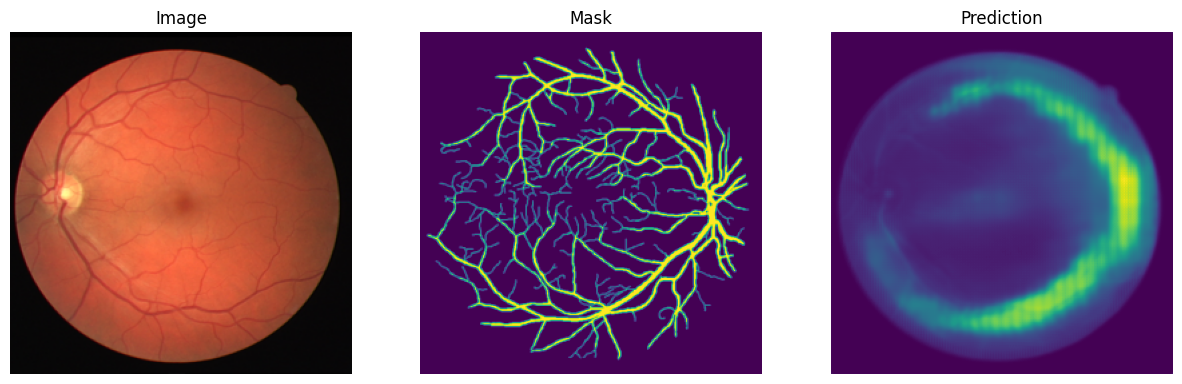

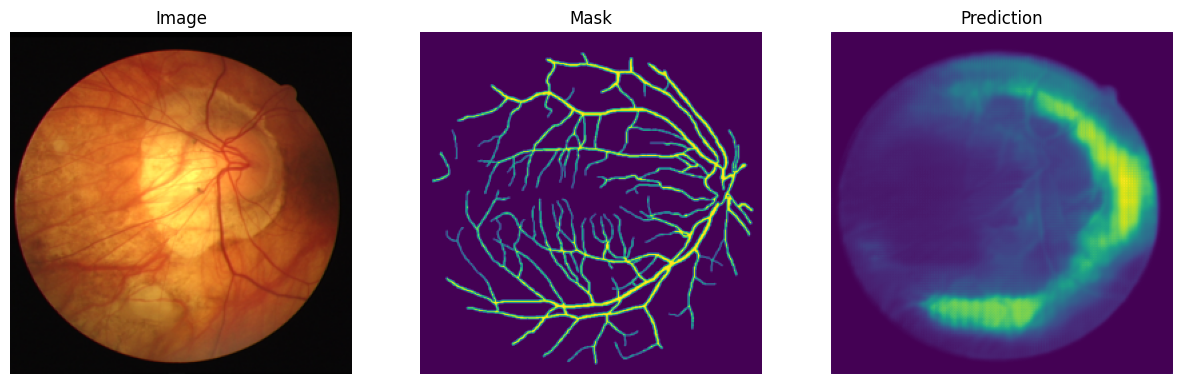

In [15]:
# Predictions for 3 images
model.eval()
with torch.no_grad():
    for i, (image, mask) in enumerate(train_loader):
        image = image.to(device)
        mask = mask.to(device)
        
        # Forward pass
        outputs = model(image)

        # Display the first 3 images
        if i < 3:
            show_image(image[0].cpu().permute(1, 2, 0), mask[0].cpu().permute(1, 2, 0), outputs[0].cpu().permute(1, 2, 0))
        else:
            break